# Remove sentences with only 1 word

In [2]:
import pickle
import os
import pandas as pd
from tqdm import tqdm
from string import punctuation
from sacremoses import MosesTokenizer
from collections import defaultdict

punctuation_to_remove = punctuation.replace("'", "").replace("-", "")
tokenizer = MosesTokenizer(lang='en')

def dump_pickle(file_path, object):
    with open(file_path, 'wb') as handle:
        pickle.dump(object, handle)

def load_pickle(file_path):
    with open(file_path, 'rb') as handle:
        object = pickle.load(handle)
    return object


def filter_remove_1word():
    PICKLE_PATH = "../pickles"
    filtered_data = []
    
    for _, _, files in os.walk(PICKLE_PATH):
        for file in sorted(files):
            if file.startswith("tosdr_block"):
                print("Processing", file)
                block_dicts = load_pickle(PICKLE_PATH + '/' + file)
                for block_dict in tqdm(block_dicts):
                    text = block_dict["text"]
                    summary = block_dict["summary"]
                    
                    filtered_text = []
                    for sent in text:
                        words_per_sent = tokenizer.tokenize(sent.translate(str.maketrans('', '', punctuation_to_remove)))
                        if len(words_per_sent) > 1:
                            filtered_text.append(sent)
                    
                    filtered_summary = []
                    for sent in summary:
                        words_per_sent = tokenizer.tokenize(sent.translate(str.maketrans('', '', punctuation_to_remove)))
                        if len(words_per_sent) > 1:
                            filtered_summary.append(sent)
                            
                    filtered_data.append({"text": filtered_text,
                                          "summary": filtered_summary})
    dump_pickle(PICKLE_PATH + '/tosdr_v2_removed_1word.pickle', filtered_data)
                    

In [13]:
filter_remove_1word()

Processing tosdr_block_0.pickle


100%|██████████| 180/180 [00:03<00:00, 51.31it/s]


Processing tosdr_block_1.pickle


100%|██████████| 158/158 [00:02<00:00, 57.85it/s]


Processing tosdr_block_10.pickle


100%|██████████| 153/153 [00:02<00:00, 51.40it/s]


Processing tosdr_block_11.pickle


100%|██████████| 129/129 [00:01<00:00, 83.93it/s]


Processing tosdr_block_12.pickle


100%|██████████| 116/116 [00:01<00:00, 73.54it/s]


Processing tosdr_block_2.pickle


100%|██████████| 169/169 [00:02<00:00, 66.89it/s]


Processing tosdr_block_3.pickle


100%|██████████| 153/153 [00:03<00:00, 41.69it/s]


Processing tosdr_block_4.pickle


100%|██████████| 154/154 [00:02<00:00, 68.99it/s]


Processing tosdr_block_5.pickle


100%|██████████| 153/153 [00:02<00:00, 64.85it/s]


Processing tosdr_block_6.pickle


100%|██████████| 165/165 [00:02<00:00, 60.82it/s]


Processing tosdr_block_7.pickle


100%|██████████| 188/188 [00:02<00:00, 68.35it/s]


Processing tosdr_block_8.pickle


100%|██████████| 166/166 [00:02<00:00, 73.11it/s]


Processing tosdr_block_9.pickle


100%|██████████| 175/175 [00:03<00:00, 57.52it/s]


In [14]:
dicts = load_pickle("../pickles/tosdr_v2_removed_1word.pickle")
stats = []
for i, block_dict in enumerate(tqdm(dicts)):
    text = block_dict["text"]
    summary = block_dict["summary"]
    len_text, len_summary = len(text), len(summary)
    
    stats.append({ 
                    "idx_in_block": i, 
                    "num_sent_text": len_text, 
                    "num_sent_summary": len_summary,
                    "sent_ratio": len_summary / len_text,
                    })
                    
main_df = pd.DataFrame.from_records(stats)
dump_pickle('../pickles/tosdr_stats_v2_main_df.pickle', main_df)

100%|██████████| 2059/2059 [00:00<00:00, 1782470.99it/s]


# Remove outliers

In [6]:
main_df = load_pickle("../pickles/tosdr_stats_v2_main_df.pickle")

In [7]:
main_df.describe()

,idx_in_block,num_sent_text,num_sent_summary,sent_ratio
count,2059.000000,2059.000000,2059.000000,2059.000000
mean,1029.000000,221.826129,14.197183,0.099767
std,594.526422,269.213251,19.463129,0.114030
min,0.000000,3.000000,0.000000,0.000000
25%,514.500000,80.000000,3.000000,0.022648
50%,1029.000000,165.000000,8.000000,0.060606
75%,1543.500000,276.000000,19.000000,0.138288
max,2058.000000,4067.000000,358.000000,1.000000


In [3]:
filtered_data = load_pickle("../pickles/tosdr_v2_removed_1word.pickle")

In [4]:
outlier_indices = set()

## # sentences in text

<AxesSubplot:>

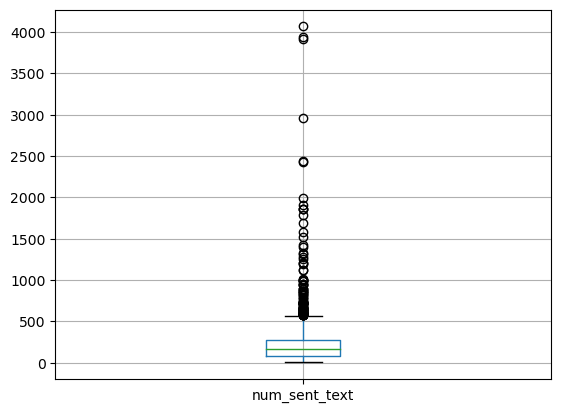

In [34]:
main_df.boxplot(column='num_sent_text')

In [53]:
main_df["num_sent_text"].quantile(0.01)

10.580000000000002

In [48]:
main_df.loc[main_df['num_sent_text'] < 10]

,idx_in_block,num_sent_text,num_sent_summary,sent_ratio
39,39,6,2,0.333333
135,135,6,2,0.333333
217,217,6,1,0.166667
350,350,4,3,0.750000
832,832,3,1,0.333333
950,950,8,1,0.125000
1058,1058,7,4,0.571429
1187,1187,4,3,0.750000
1209,1209,7,1,0.142857
1234,1234,9,3,0.333333


In [8]:
outlier_indices.update(main_df.loc[main_df['num_sent_text'] < 10]['idx_in_block'].tolist())

## # sentences in summary

In [60]:
main_df.loc[main_df["num_sent_summary"] == 0]

,idx_in_block,num_sent_text,num_sent_summary,sent_ratio
688,688,224,0,0.0


In [9]:
outlier_indices.update(main_df.loc[main_df["num_sent_summary"] == 0]["idx_in_block"].tolist())

## sentence ratio

In [78]:
main_df['sent_ratio'].quantile(0.99)

0.5176315789473692

In [77]:
main_df.loc[main_df['sent_ratio'] >= 0.6]

,idx_in_block,num_sent_text,num_sent_summary,sent_ratio
26,26,147,147,1.000000
225,225,13,13,1.000000
287,287,222,179,0.806306
350,350,4,3,0.750000
693,693,15,9,0.600000
802,802,60,38,0.633333
908,908,293,254,0.866894
909,909,387,358,0.925065
1151,1151,46,34,0.739130
1187,1187,4,3,0.750000


In [10]:
outlier_indices.update(main_df.loc[main_df['sent_ratio'] >= 0.7]['idx_in_block'].tolist())

In [12]:
print(outlier_indices)

{135, 908, 909, 26, 287, 1058, 1187, 1826, 39, 688, 950, 1209, 1340, 1855, 832, 1486, 1872, 1234, 2002, 217, 350, 225, 1765, 1897, 1260, 1773, 1270, 1151}


# Final filtered output

In [84]:
final_df = main_df.drop(outlier_indices)

In [86]:
final_df

,idx_in_block,num_sent_text,num_sent_summary,sent_ratio
0,0,326,4,0.012270
1,1,29,5,0.172414
2,2,311,19,0.061093
3,3,338,72,0.213018
4,4,141,19,0.134752
...,...,...,...,...
2054,2054,298,15,0.050336
2055,2055,42,12,0.285714
2056,2056,53,10,0.188679
2057,2057,313,2,0.006390


In [87]:
final_df.describe()

,idx_in_block,num_sent_text,num_sent_summary,sent_ratio
count,2031.000000,2031.000000,2031.000000,2031.000000
mean,1028.537666,224.151649,13.873461,0.094083
std,594.214698,270.072216,16.543814,0.097406
min,0.000000,10.000000,1.000000,0.000838
25%,514.500000,82.000000,3.000000,0.022490
50%,1027.000000,166.000000,8.000000,0.059406
75%,1543.500000,278.000000,19.000000,0.135028
max,2058.000000,4067.000000,192.000000,0.633333
